# Deconvolution
[Grant et al](https://github.com/NUPulmonary/2020_Grant) dataset as single-cell reference.

In [1]:
import itertools
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import importlib
import scipy as sci
import seaborn as sns
import statannot

import datetime
import autogenes as ag
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import statsmodels.stats.multitest
from matplotlib.patches import Patch

### Hide warnings

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Get table of Ensembl gene ID to gene symbol conversions - pull from gene features in one sample

In [3]:
genes = sc.read_10x_h5('../data/GSM4698176_Sample_1_raw_feature_bc_matrix.h5').var

In [4]:
genes = genes[genes.gene_ids.str.startswith("GRCh38")]

In [5]:
genes = genes.rename(columns={'gene_ids': 'ensembl_id'})

In [6]:
genes.index = genes.index.str.replace("^GRCh38_+", "")
genes.ensembl_id = genes.ensembl_id.str.replace("^GRCh38_+", "")

In [7]:
genes = genes[~genes.index.duplicated()]

In [8]:
genes = genes.drop(columns=['feature_types','genome'])

In [9]:
genes

,ensembl_id
MIR1302-2HG,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
AL627309.1,ENSG00000238009
AL627309.3,ENSG00000239945
...,...
AC233755.2,ENSG00000277856
AC233755.1,ENSG00000275063
AC240274.1,ENSG00000271254
AC213203.1,ENSG00000277475


### Load [single cell reference object](https://www.nupulmonary.org/covid-19-ms1/?ds=30obj-covid-export-cb).

In [10]:
adata = sc.read_h5ad("../data/GSE155249_main.h5ad")

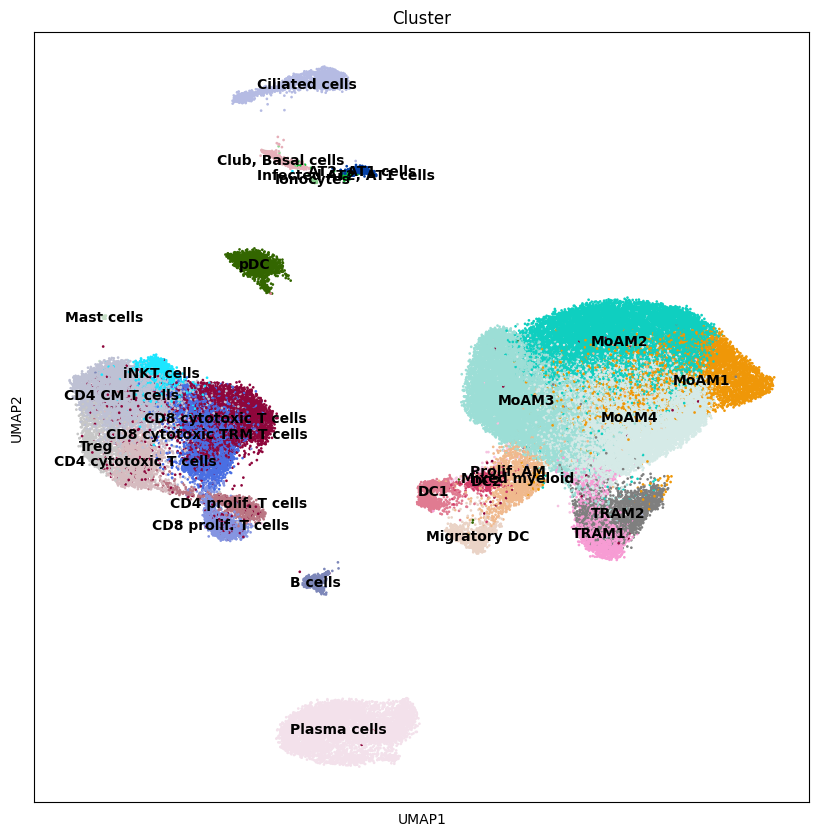

In [12]:
mpl.rcParams["figure.figsize"] = (10, 10)
sc.pl.umap(adata, color="Cluster", size=15, legend_loc="on data")

### Get raw (not scaled) counts

In [13]:
adata_raw = adata.raw.to_adata()

### Reverse log-transform to get just normalized gene counts (to 10k/cell)

In [14]:
adata_raw.X = np.expm1(adata_raw.X)

### Name genes with Ensembl ID to make compatible with bulk data
Set var_names to ensembl ID

In [15]:
adata_raw.var = adata_raw.var.rename(columns={'gene_ids-0': 'ensembl_id'})

In [16]:
adata_raw.var.ensembl_id = adata_raw.var.ensembl_id.str.replace("^GRCh38_+", "")

In [17]:
adata_raw.var['gene_name'] = adata_raw.var.index.copy()

# Deconvolution on CD8 T cells

In [18]:
adata_raw = adata_raw[adata_raw.obs.Cluster.isin(['CD8 cytotoxic T cells',
                                        'CD8 cytotoxic TRM T cells',
                                        'CD8 prolif. T cells'])]

### Read in bulk count data

In [19]:
abulks = sc.read_text("../data/01bulk-counts.tsv", first_column_names=True).T

In [20]:
sample_cell_types = pd.read_csv("../data/tcell_samples_bulk.csv", index_col=0)

In [21]:
abulks = abulks[abulks.obs_names.isin(sample_cell_types.sample_id)]

In [22]:
abulks.obs = pd.merge(abulks.obs, sample_cell_types, left_index=True, right_on='sample_id')

In [23]:
abulks.obs = abulks.obs.set_index('sample_id')

In [24]:
abulks.obs.index.name = None

In [26]:
abulks = abulks[abulks.obs.cell_type2 == 'CD8']

In [27]:
sc.pp.filter_genes(abulks, min_cells=1)

In [28]:
adata_raw.shape

(8968, 21819)

In [29]:
sc.pp.filter_genes(adata_raw, min_cells=20)
adata_raw.n_vars

12762

In [30]:
sc.pp.normalize_per_cell(abulks, counts_per_cell_after=1e4, copy=False)

In [31]:
np.intersect1d(adata_raw.var_names, abulks.var_names).size - adata_raw.n_vars

-1468

In [32]:
adata_raw = adata_raw[:, np.intersect1d(adata_raw.var_names, abulks.var_names)]
abulks = abulks[:, np.intersect1d(adata_raw.var_names, abulks.var_names)]

In [33]:
adata_raw_log = sc.pp.log1p(adata_raw, copy=True)

### Compute 1000 HVGs in log-space, take the normalized counts for them

In [34]:
sc.pp.highly_variable_genes(adata_raw_log, flavor='seurat', n_top_genes=1000, batch_key="Sample")

In [35]:
adata_raw_hv = adata_raw[:, adata_raw_log.var['highly_variable']].copy()

In [36]:
adata_raw_hv.shape

(8968, 1000)

In [37]:
set(adata_raw_hv.obs["Cluster"])

{'CD8 cytotoxic T cells', 'CD8 cytotoxic TRM T cells', 'CD8 prolif. T cells'}

In [38]:
adata_raw_hv.X = adata_raw_hv.X.todense()

In [39]:
adata_raw_hv.obs.Cluster = adata_raw_hv.obs.Cluster.astype(str)

In [40]:
print(datetime.datetime.now())
time0 = datetime.datetime.now()

ngenes = 200
ngen = 2000
centroids = ag.init(adata_raw_hv, use_highly_variable=False, celltype_key='Cluster')
ag.optimize(ngen=ngen, seed=0, nfeatures=ngenes, mode='fixed', verbose=False)

print(datetime.datetime.now() - time0)

2023-10-30 13:48:02.114163
0:01:09.573760


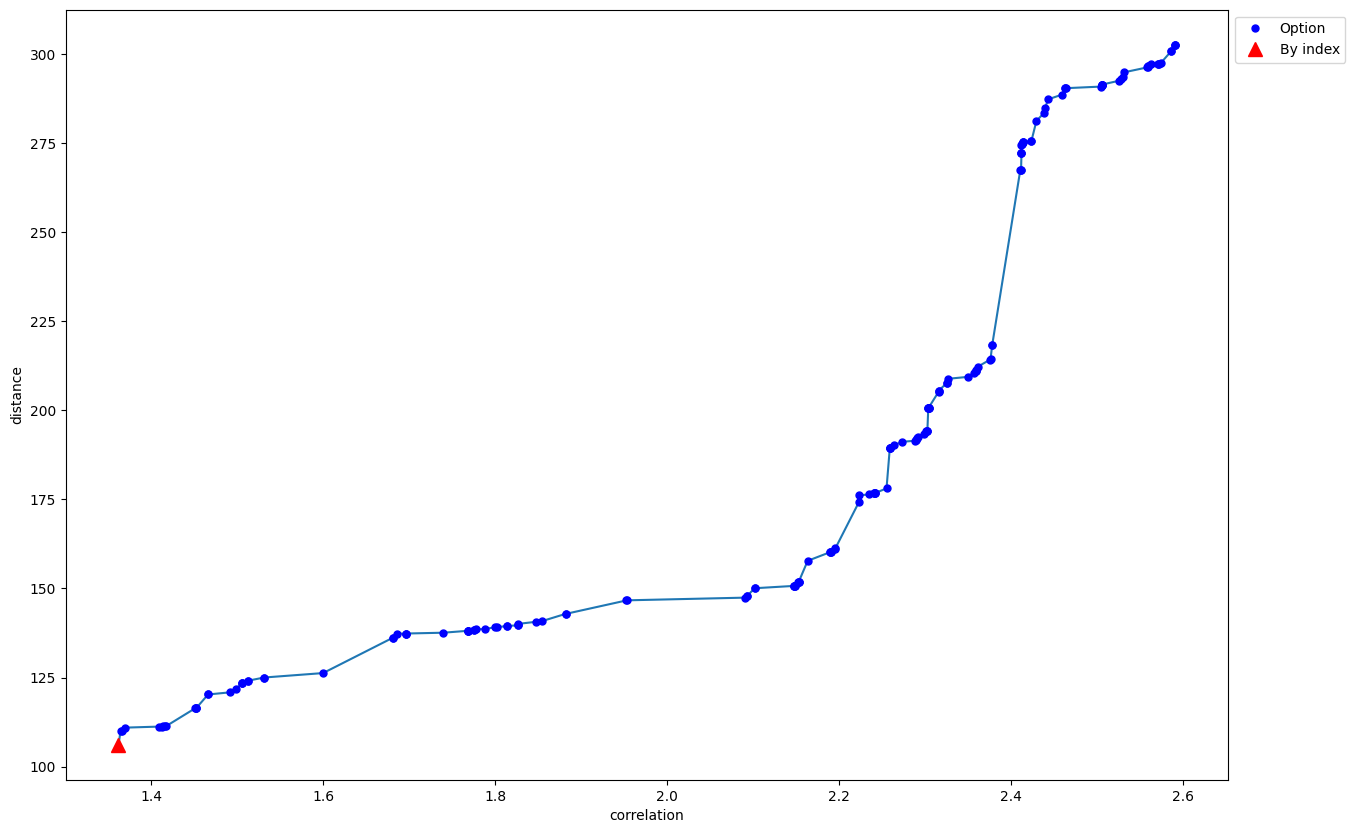

In [41]:
ag.plot(index=0)

In [42]:
ag.fitness_matrix()[0, 0]

1.3619706642911995

All dots here are solutions to deconvolution problem in the form of a set of 400 genes. Each set has two characteristics: correlation, which we are trying to minimize, and distance, which we are trying to maximize. The higher the correlation, the more mixture between cell types we will have. The lower the distance, the less power to separate cell types. I picked this solution because of low correlation and checked with a graph below.

In [43]:
selection = ag.select(index=0)

centroids_sc_pareto = pd.DataFrame(
    centroids[:,selection].X.T,
    index=centroids[:,selection].var_names,
    columns=centroids[:,selection].obs_names
)

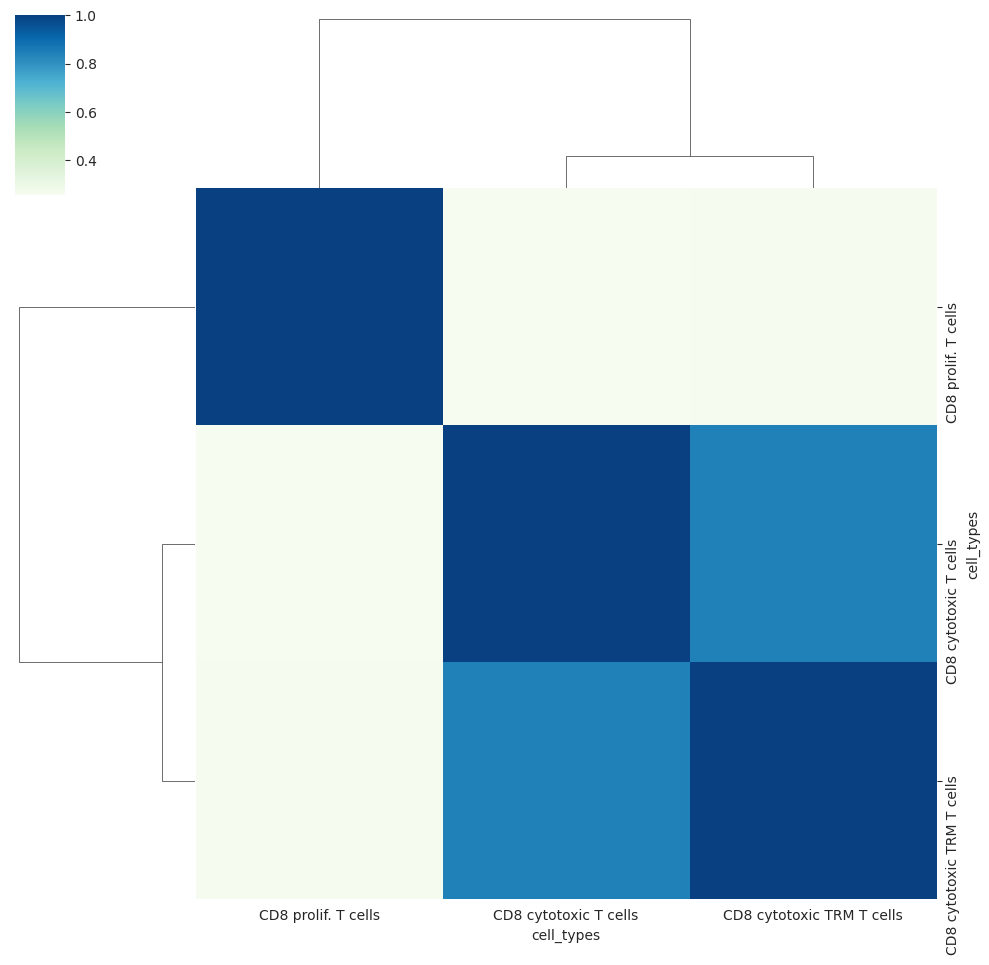

In [44]:
corr = pd.DataFrame(
    data=np.corrcoef(centroids_sc_pareto.T), 
    columns=centroids_sc_pareto.columns, 
    index=centroids_sc_pareto.columns
)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns_plot = sns.clustermap(np.abs(corr), cmap=sns.color_palette("GnBu", 1000), robust=True)

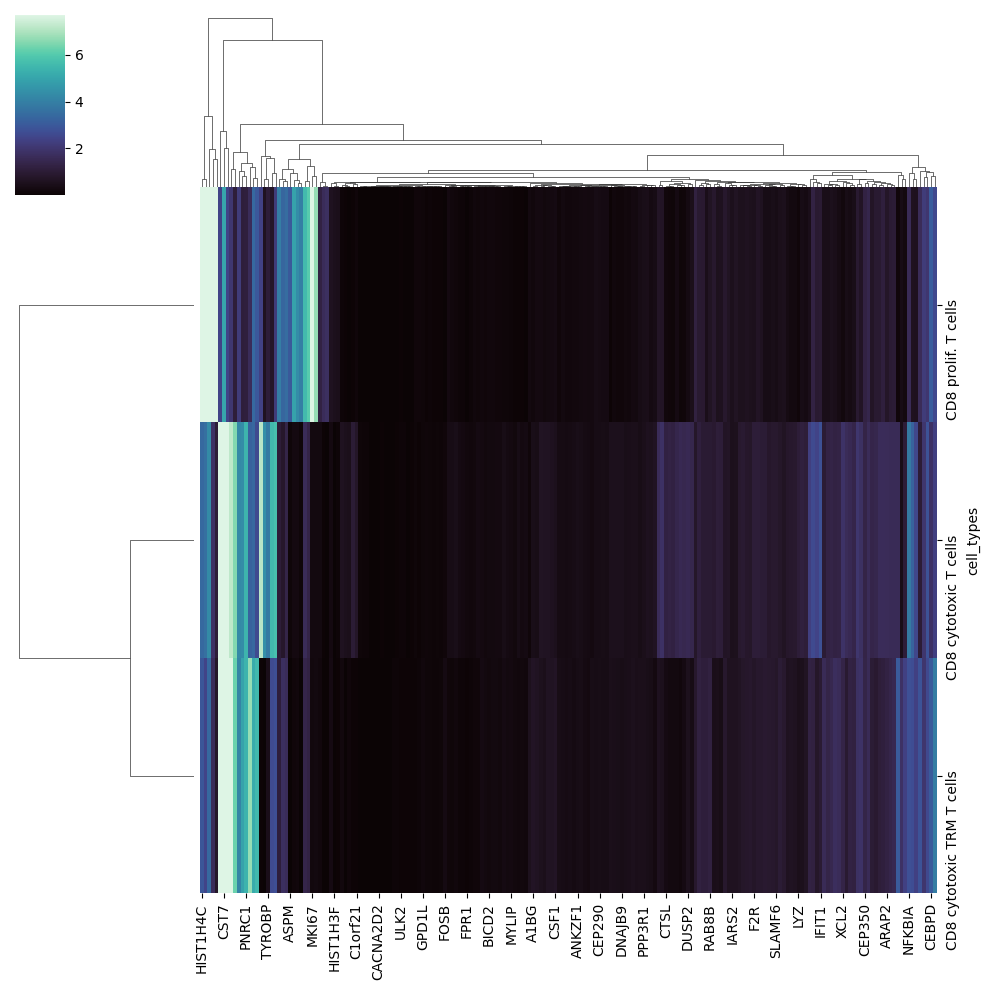

In [45]:
subTypes = pd.Series(centroids_sc_pareto.columns.astype(str))
type_pal = sns.husl_palette(centroids_sc_pareto.columns.size, s=0.7)
lut = dict(zip(centroids_sc_pareto.columns.astype(str).unique().values, type_pal))
row_colors = subTypes.map(lut)
sns_plot = sns.clustermap(centroids_sc_pareto.T, cmap="mako", robust=True) #, cmap="mako", robust=True, row_cluster = False)

In [46]:
sig_genes = centroids_sc_pareto.loc[:, ['CD8 cytotoxic T cells',
       'CD8 cytotoxic TRM T cells', 'CD8 prolif. T cells']].copy()

In [47]:
sig_genes.to_csv("../data/MS1/sig_genes_MS1_CD8.csv")

In [48]:
pd.DataFrame(sig_genes).merge(genes, left_index=True, right_index=True).head(30)

,CD8 cytotoxic T cells,CD8 cytotoxic TRM T cells,CD8 prolif. T cells,ensembl_id
A1BG,0.425191,0.700900,0.189835,ENSG00000121410
AGER,0.041500,0.047413,0.022619,ENSG00000204305
AHNAK,4.252164,4.117266,2.199526,ENSG00000124942
AIF1,1.072456,0.476562,0.539213,ENSG00000204472
AKT3,0.268732,0.205421,0.051721,ENSG00000117020
ALOX5AP,10.275412,9.594004,2.426118,ENSG00000132965
ANKRD36,0.346867,0.348864,0.362239,ENSG00000135976
ANKRD49,0.485771,0.496215,0.255794,ENSG00000168876
ANKZF1,0.406223,0.364617,0.194048,ENSG00000163516
AOAH,1.535164,1.271866,0.314189,ENSG00000136250


In [49]:
abulks_hv = abulks[:, adata_raw_log.var['highly_variable']]

In [50]:
abulks_hv.shape

(156, 1000)

In [51]:
coef_nnls = ag.deconvolve(abulks_hv.X, model='nnls') #model='nusvr'
coef_nnls.shape

(156, 3)

In [52]:
def normalize_proportions(data, copy):
    if copy == True:
        data_copy = data.copy()
    else:
        data_copy = data
    data_copy[data_copy < 0] = 0
    for raw in data_copy.index:
        sum = data_copy.loc[raw].sum()
        if sum != 0:
            data_copy.loc[raw] = np.divide(data_copy.loc[raw], sum)
        else:
            data_copy.loc[raw] = 0
    return data_copy

In [53]:
proportions_nnls = pd.DataFrame(data=coef_nnls.T, index = centroids_sc_pareto.columns, columns = abulks_hv.obs_names)
proportions_nnls_norm = normalize_proportions(proportions_nnls.T,copy=True).T

In [54]:
proportions_nnls_norm = proportions_nnls_norm.set_index(proportions_nnls_norm.index)
proportions_nnls_norm = proportions_nnls_norm.astype(float)

In [55]:
proportions = proportions_nnls_norm.copy()

### Add cell type metadata to heatmap

In [56]:
cols_meta = abulks.obs.loc[:,['cell_type2']].copy()
cols = cols_meta.copy()

In [57]:
lut = dict(zip(cols.cell_type2.unique(), ["#4DBBD5", "#3C5488", "#00A087"]))
cols.cell_type2 = cols.cell_type2.map(lut)

In [58]:
cols.columns = ["Cell type"]

In [57]:
proportions.to_csv("../data/MS1/proportions_MS1_CD8.csv")

In [59]:
proportions = pd.read_csv("../data/MS1/proportions_MS1_CD8.csv", index_col=0)
proportions

,S300291669,S300291966,S300291991,S300292234,S300292686,S300306513,S300306687,S300306692,S300306712,S300306713,...,S360796363,S360796373,S360796388,S360796464,S360796504,S360800864,S360800885,S368500693,S368500723,S368500728
cell_types,,,,,,,,,,,,,,,,,,,,,
CD8 cytotoxic T cells,0.839045,0.387078,0.966047,0.442668,0.563854,0.751126,0.450974,0.162790,0.241066,0.281391,...,0.139882,0.047309,0.178909,0.132293,0.094229,0.0,0.0,0.220268,0.260485,0.256053
CD8 cytotoxic TRM T cells,0.000000,0.612922,0.000000,0.470023,0.328327,0.248874,0.549026,0.828236,0.736691,0.593793,...,0.808888,0.662450,0.776986,0.867707,0.900413,1.0,1.0,0.779732,0.739515,0.455306
CD8 prolif. T cells,0.160955,0.000000,0.033953,0.087309,0.107819,0.000000,0.000000,0.008974,0.022243,0.124815,...,0.051230,0.290240,0.044105,0.000000,0.005357,0.0,0.0,0.000000,0.000000,0.288641


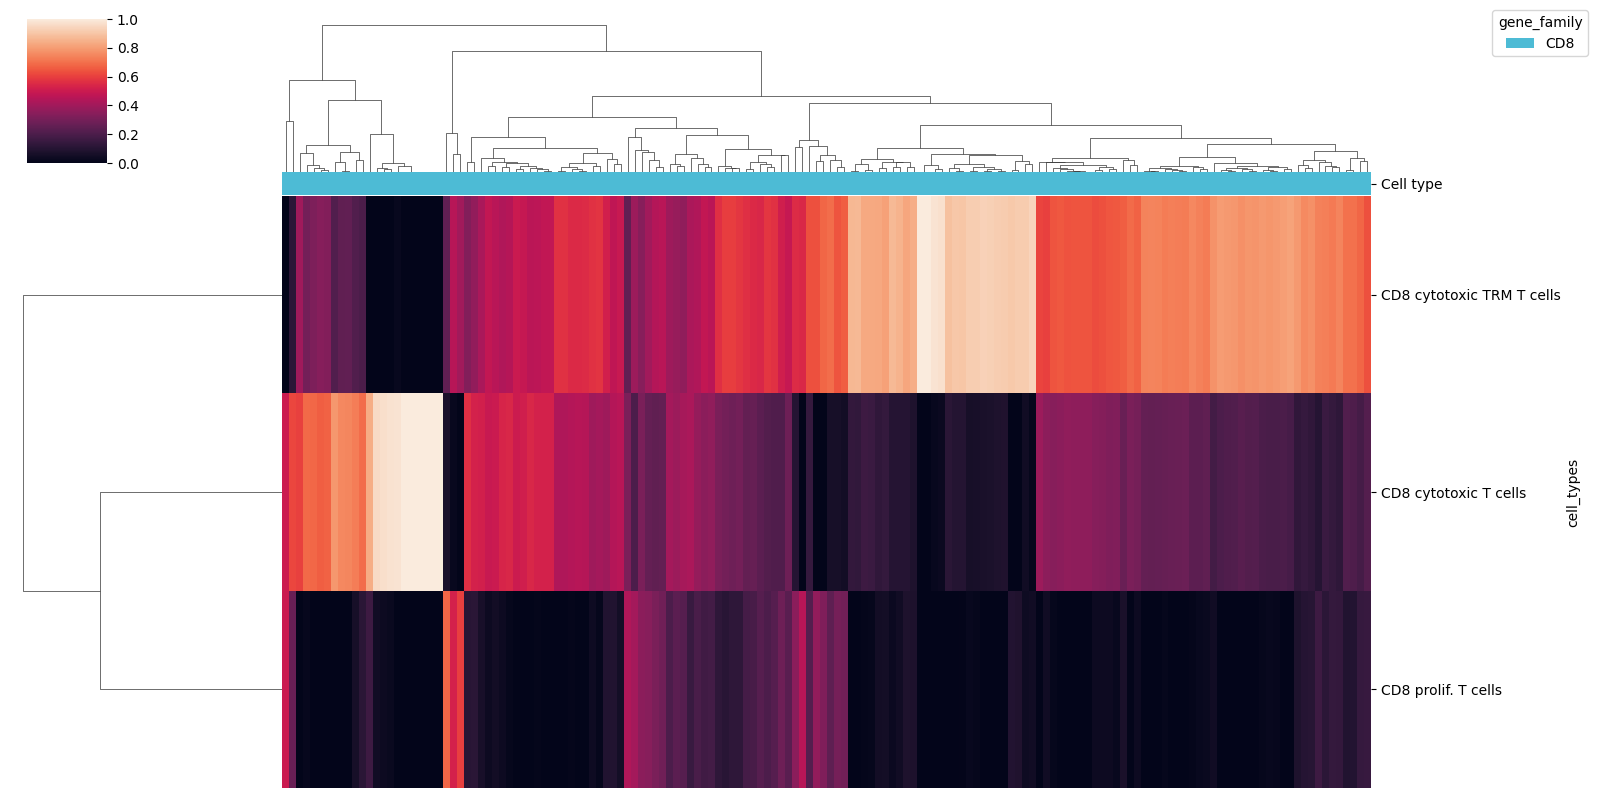

In [60]:
ax = sns.clustermap(
    proportions, 
    col_cluster=True, 
    row_cluster=True, 
    xticklabels=False, 
    figsize=(16, 8),
    col_colors=cols,
    linecolor="none",
    snap=True
)

handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='gene_family',
           bbox_to_anchor=(0, 0, 1, 1), bbox_transform=plt.gcf().transFigure, loc='best')

# Deconvolution analysis for CD4 + Tregs

### Get table of Ensembl gene ID to gene symbol conversions - pull from gene features in one sample

In [61]:
genes = sc.read_10x_h5('../data/GSM4698176_Sample_1_raw_feature_bc_matrix.h5').var

In [62]:
genes = genes[genes.gene_ids.str.startswith("GRCh38")]

In [63]:
genes = genes.rename(columns={'gene_ids': 'ensembl_id'})

In [64]:
genes.index = genes.index.str.replace("^GRCh38_+", "")
genes.ensembl_id = genes.ensembl_id.str.replace("^GRCh38_+", "")

In [65]:
genes = genes[~genes.index.duplicated()]

In [66]:
genes = genes.drop(columns=['feature_types','genome'])

In [67]:
genes

,ensembl_id
MIR1302-2HG,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
AL627309.1,ENSG00000238009
AL627309.3,ENSG00000239945
...,...
AC233755.2,ENSG00000277856
AC233755.1,ENSG00000275063
AC240274.1,ENSG00000271254
AC213203.1,ENSG00000277475


### Load [single cell reference object](https://www.nupulmonary.org/covid-19-ms1/?ds=30obj-covid-export-cb) - MS1 

In [68]:
adata = sc.read_h5ad("../data/GSE155249_main.h5ad")

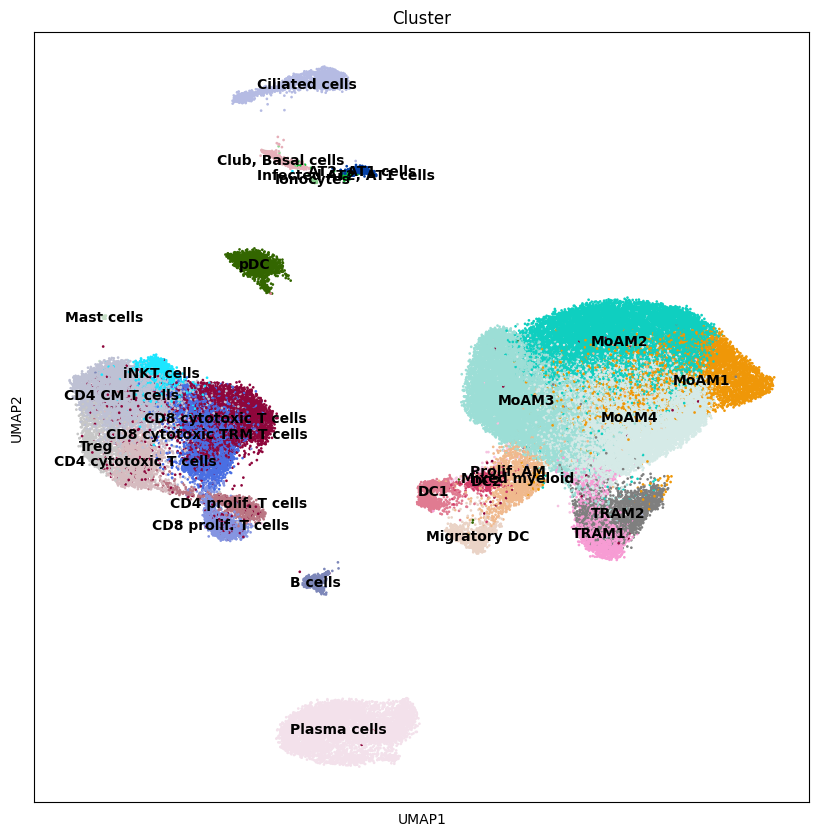

In [69]:
mpl.rcParams["figure.figsize"] = (10, 10)
sc.pl.umap(adata, color="Cluster", size=15, legend_loc="on data")

### Get raw (not scaled) counts

In [70]:
adata_raw = adata.raw.to_adata()

### Reverse log-transform to get just normalized gene counts (to 10k/cell)

In [71]:
adata_raw.X = np.expm1(adata_raw.X)

### Name genes with Ensembl ID to make compatible with bulk data
Set var_names to ensembl ID

In [72]:
adata_raw.var = adata_raw.var.rename(columns={'gene_ids-0': 'ensembl_id'})

In [73]:
adata_raw.var.ensembl_id = adata_raw.var.ensembl_id.str.replace("^GRCh38_+", "")

In [74]:
adata_raw.var['gene_name'] = adata_raw.var.index.copy()

### Subset on CD4 T cells + Tregs

In [75]:
adata_raw = adata_raw[adata_raw.obs.Cluster.isin(['CD4 CM T cells',
                                        'CD4 cytotoxic T cells',
                                        'CD4 prolif. T cells','Treg'])]

### Read in bulk count data

In [76]:
abulks = sc.read_text("../data/01bulk-counts.tsv", first_column_names=True).T

In [77]:
sample_cell_types = pd.read_csv("../data/tcell_samples_bulk.csv", index_col=0)

In [78]:
abulks = abulks[abulks.obs_names.isin(sample_cell_types.sample_id)]

In [79]:
abulks.obs = pd.merge(abulks.obs, sample_cell_types, left_index=True, right_on='sample_id')

In [80]:
abulks.obs = abulks.obs.set_index('sample_id')

In [81]:
abulks.obs.index.name = None

In [82]:
abulks = abulks[abulks.obs.cell_type2.isin(['CD4','Treg'])]

In [83]:
sc.pp.filter_genes(abulks, min_cells=1)

In [84]:
adata_raw.shape

(9234, 21819)

In [85]:
sc.pp.filter_genes(adata_raw, min_cells=20)
adata_raw.n_vars

12533

In [86]:
sc.pp.normalize_per_cell(abulks, counts_per_cell_after=1e4, copy=False)

In [87]:
np.intersect1d(adata_raw.var_names, abulks.var_names).size - adata_raw.n_vars

-1460

In [88]:
adata_raw = adata_raw[:, np.intersect1d(adata_raw.var_names, abulks.var_names)]
abulks = abulks[:, np.intersect1d(adata_raw.var_names, abulks.var_names)]

In [89]:
adata_raw_log = sc.pp.log1p(adata_raw, copy=True)

### Compute 1000 HVGs in log-space, take the normalized counts for them

In [90]:
sc.pp.highly_variable_genes(adata_raw_log, flavor='seurat', n_top_genes=1000, batch_key="Sample")

In [91]:
adata_raw_hv = adata_raw[:, adata_raw_log.var['highly_variable']].copy()

In [92]:
adata_raw_hv.shape

(9234, 1000)

In [93]:
set(adata_raw_hv.obs["Cluster"])

{'CD4 CM T cells', 'CD4 cytotoxic T cells', 'CD4 prolif. T cells', 'Treg'}

In [94]:
adata_raw_hv.X = adata_raw_hv.X.todense()

In [95]:
adata_raw_hv.obs.Cluster = adata_raw_hv.obs.Cluster.astype(str)

In [96]:
print(datetime.datetime.now())
time0 = datetime.datetime.now()

ngenes = 150
ngen = 2000
centroids = ag.init(adata_raw_hv, use_highly_variable=False, celltype_key='Cluster')
ag.optimize(ngen=ngen, seed=0, nfeatures=ngenes, mode='fixed', verbose=False)

print(datetime.datetime.now() - time0)

2023-10-30 13:51:52.141164
0:01:07.337618


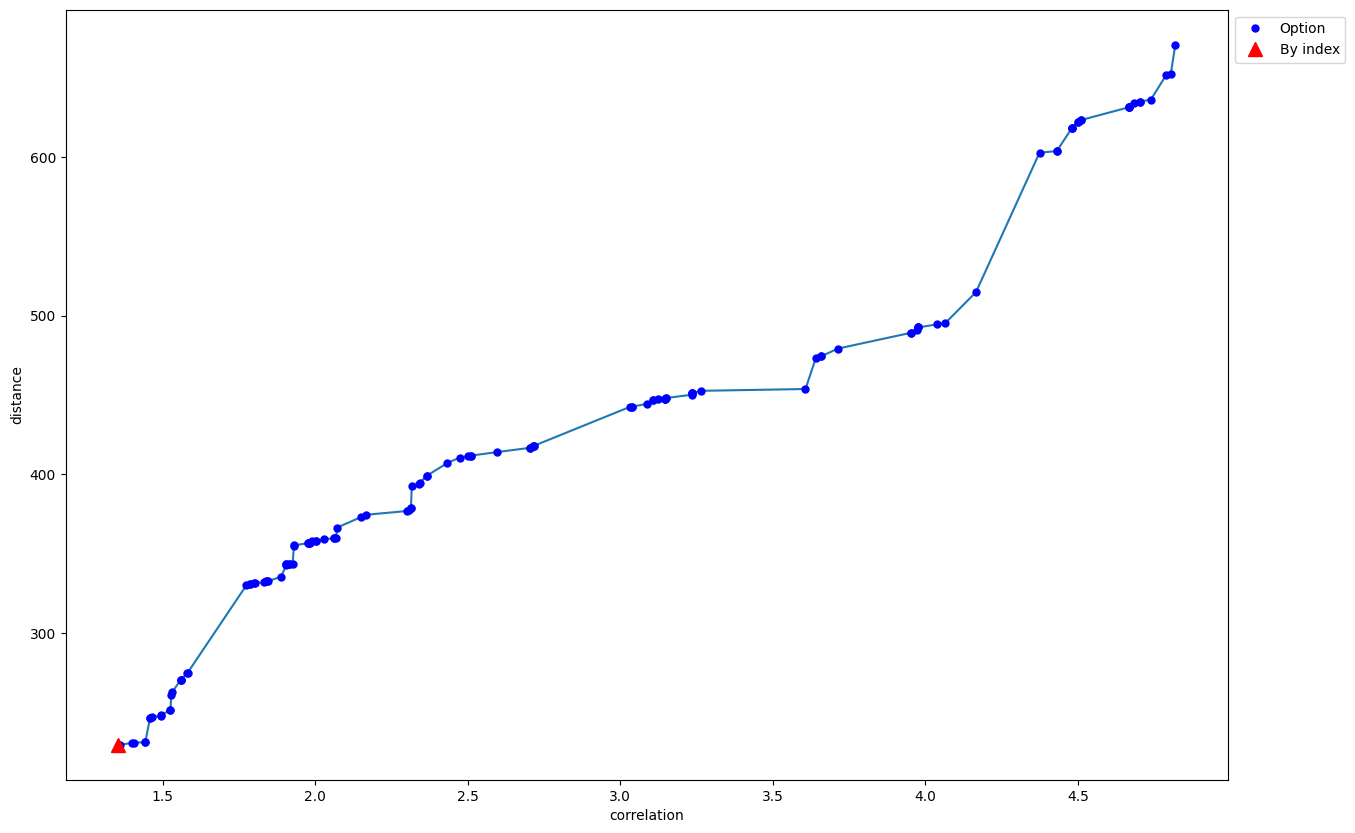

In [97]:
ag.plot(index=0)

In [98]:
ag.fitness_matrix()[0, 0]

1.3551003837973328

All dots here are solutions to deconvolution problem in the form of a set of 400 genes. Each set has two characteristics: correlation, which we are trying to minimize, and distance, which we are trying to maximize. The higher the correlation, the more mixture between cell types we will have. The lower the distance, the less power to separate cell types. I picked this solution because of low correlation and checked with a graph below.

In [99]:
selection = ag.select(index=0)

centroids_sc_pareto = pd.DataFrame(
    centroids[:,selection].X.T,
    index=centroids[:,selection].var_names,
    columns=centroids[:,selection].obs_names
)

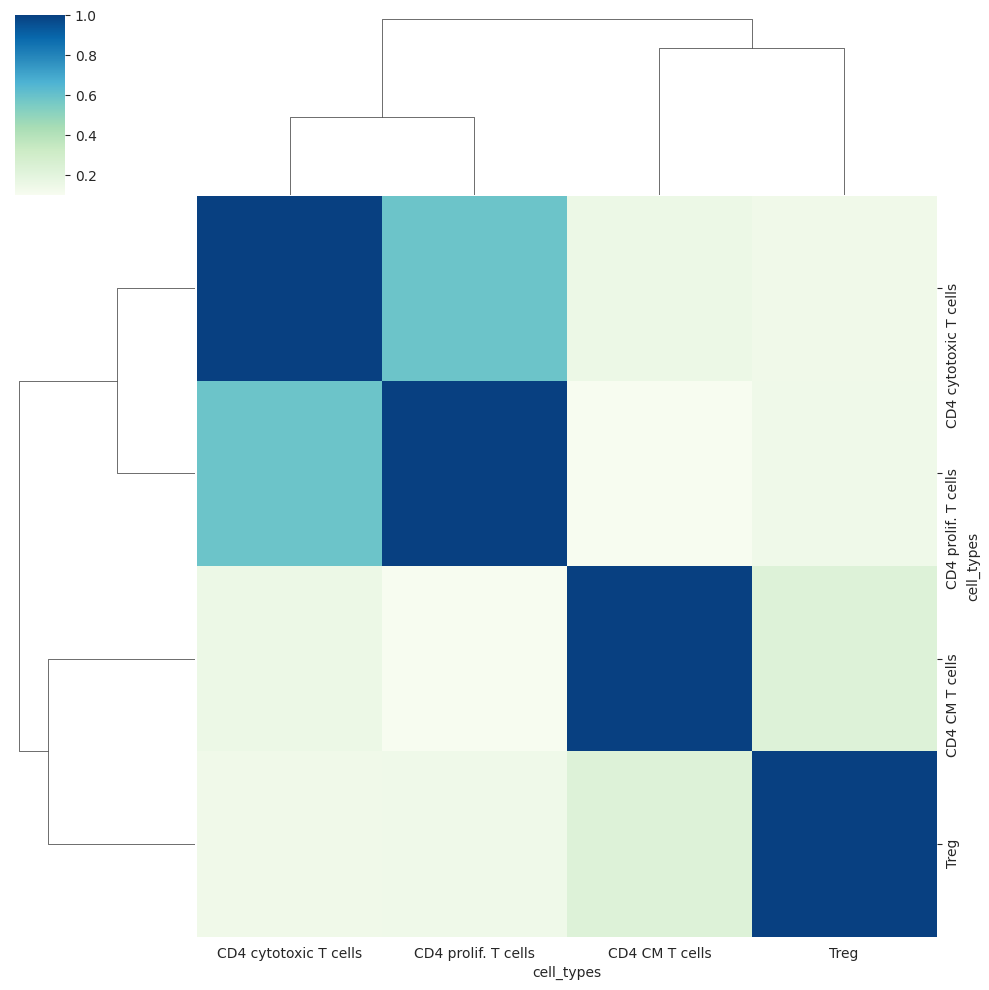

In [100]:
corr = pd.DataFrame(
    data=np.corrcoef(centroids_sc_pareto.T), 
    columns=centroids_sc_pareto.columns, 
    index=centroids_sc_pareto.columns
)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns_plot = sns.clustermap(np.abs(corr), cmap=sns.color_palette("GnBu", 1000), robust=True)

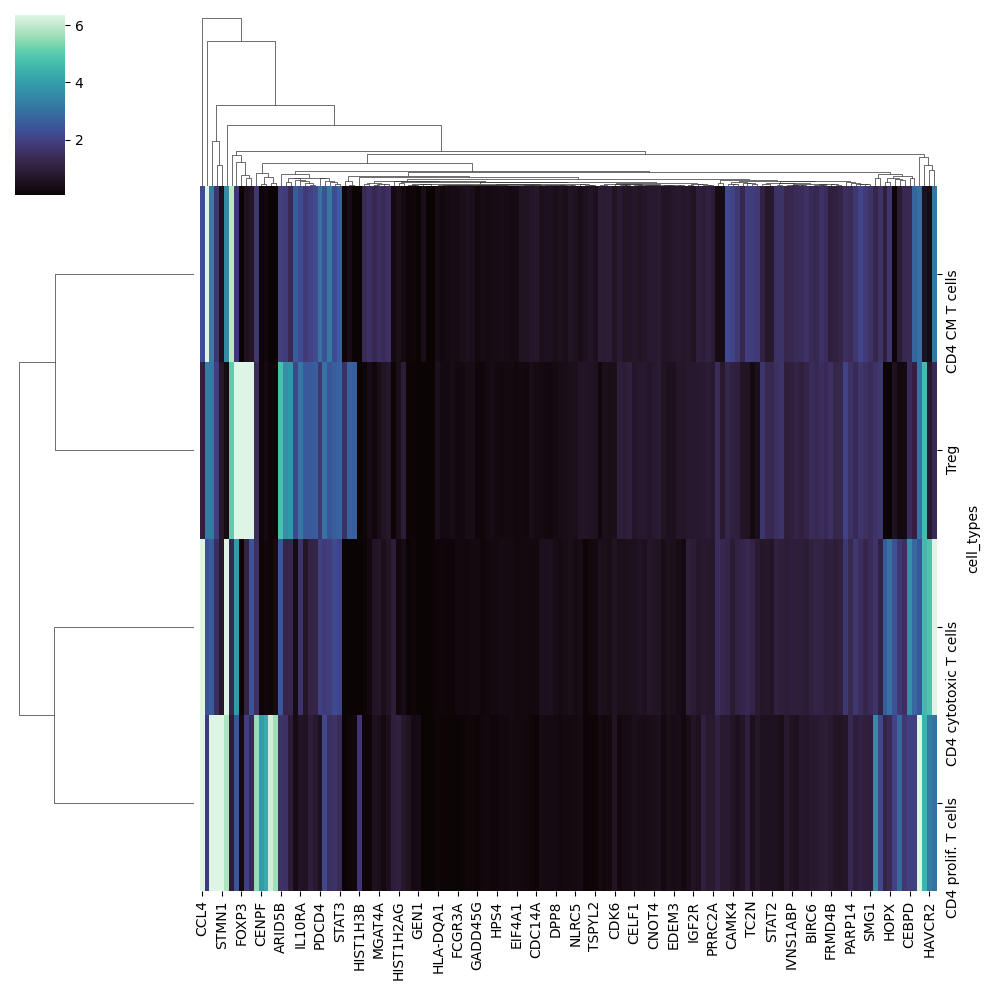

In [101]:
subTypes = pd.Series(centroids_sc_pareto.columns.astype(str))
type_pal = sns.husl_palette(centroids_sc_pareto.columns.size, s=0.7)
lut = dict(zip(centroids_sc_pareto.columns.astype(str).unique().values, type_pal))
row_colors = subTypes.map(lut)
sns_plot = sns.clustermap(centroids_sc_pareto.T, cmap="mako", robust=True) #, cmap="mako", robust=True, row_cluster = False)

In [102]:
sig_genes = centroids_sc_pareto.loc[:, ['CD4 CM T cells',
                                        'CD4 cytotoxic T cells',
                                        'CD4 prolif. T cells','Treg']].copy()

In [107]:
sig_genes.to_csv("../data/MS1/sig_genes_MS1_CD4_treg.csv")

In [103]:
pd.DataFrame(sig_genes).merge(genes, left_index=True, right_index=True).head(30)

,CD4 CM T cells,CD4 cytotoxic T cells,CD4 prolif. T cells,Treg,ensembl_id
AAK1,1.421768,0.935157,0.706984,0.999991,ENSG00000115977
ADAM10,1.022167,0.909059,0.627064,1.196846,ENSG00000137845
AFF1,0.585375,0.553662,0.373526,0.730665,ENSG00000172493
AHI1,0.166919,0.164761,0.276490,0.086511,ENSG00000135541
AKNA,1.725162,1.711727,0.963748,1.320844,ENSG00000106948
APLP2,0.627600,0.429397,0.320920,0.874479,ENSG00000084234
ARHGAP5,0.283032,0.105733,0.085090,0.254233,ENSG00000100852
ARID1B,0.638158,0.477006,0.404312,0.504135,ENSG00000049618
ARID5B,1.936255,2.465410,1.584522,4.780215,ENSG00000150347
ARL4C,2.217741,2.218496,1.590537,2.602746,ENSG00000188042


In [104]:
abulks_hv = abulks[:, adata_raw_log.var['highly_variable']]

In [105]:
abulks_hv.shape

(264, 1000)

In [106]:
coef_nnls = ag.deconvolve(abulks_hv.X, model='nnls') #model='nusvr'
coef_nnls.shape

(264, 4)

In [107]:
def normalize_proportions(data, copy):
    if copy == True:
        data_copy = data.copy()
    else:
        data_copy = data
    data_copy[data_copy < 0] = 0
    for raw in data_copy.index:
        sum = data_copy.loc[raw].sum()
        if sum != 0:
            data_copy.loc[raw] = np.divide(data_copy.loc[raw], sum)
        else:
            data_copy.loc[raw] = 0
    return data_copy

In [108]:
proportions_nnls = pd.DataFrame(data=coef_nnls.T, index = centroids_sc_pareto.columns, columns = abulks_hv.obs_names)
proportions_nnls_norm = normalize_proportions(proportions_nnls.T,copy=True).T

In [109]:
proportions_nnls_norm = proportions_nnls_norm.set_index(proportions_nnls_norm.index)
proportions_nnls_norm = proportions_nnls_norm.astype(float)

In [110]:
proportions = proportions_nnls_norm.copy()

### Add cell type metadata to heatmap

In [111]:
cols_meta = abulks.obs.loc[:,['cell_type2']].copy()
cols = cols_meta.copy()

In [112]:
lut = dict(zip(cols.cell_type2.unique(), ["#4DBBD5", "#3C5488", "#00A087"]))
cols.cell_type2 = cols.cell_type2.map(lut)

In [113]:
cols.columns = ["Cell type"]

In [119]:
proportions.to_csv("../data/MS1/proportions_MS1_CD4_treg.csv")

In [114]:
proportions = pd.read_csv("../data/MS1/proportions_MS1_CD4_treg.csv", index_col=0)
proportions

,S300291672,S300291696,S300291702,S300291726,S300291727,S300291736,S300291737,S300291956,S300292021,S300292313,...,S360800861,S360800863,S360800875,S360800890,S360812684,S368500686,S368500704,S368500729,S368500732,S368500745
cell_types,,,,,,,,,,,,,,,,,,,,,
CD4 CM T cells,0.563499,0.000000,0.960263,0.611344,0.544155,0.53442,0.104589,0.838778,0.847193,0.044019,...,0.089885,0.588541,0.118014,0.789214,0.202124,0.000000,0.684278,0.818371,0.024738,0.181346
CD4 cytotoxic T cells,0.000000,0.000000,0.000000,0.000000,0.008006,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.058040,0.000000,0.000000,0.052808,0.000000,0.000000,0.000000,0.000000,0.023981
CD4 prolif. T cells,0.059282,0.189942,0.000000,0.028476,0.009012,0.00000,0.172513,0.000000,0.000000,0.039917,...,0.254917,0.003695,0.110116,0.009707,0.125707,0.043296,0.000000,0.000000,0.220295,0.009887
Treg,0.377219,0.810058,0.039737,0.360179,0.438827,0.46558,0.722898,0.161222,0.152807,0.916064,...,0.655198,0.349724,0.771870,0.201079,0.619361,0.956704,0.315722,0.181629,0.754967,0.784787


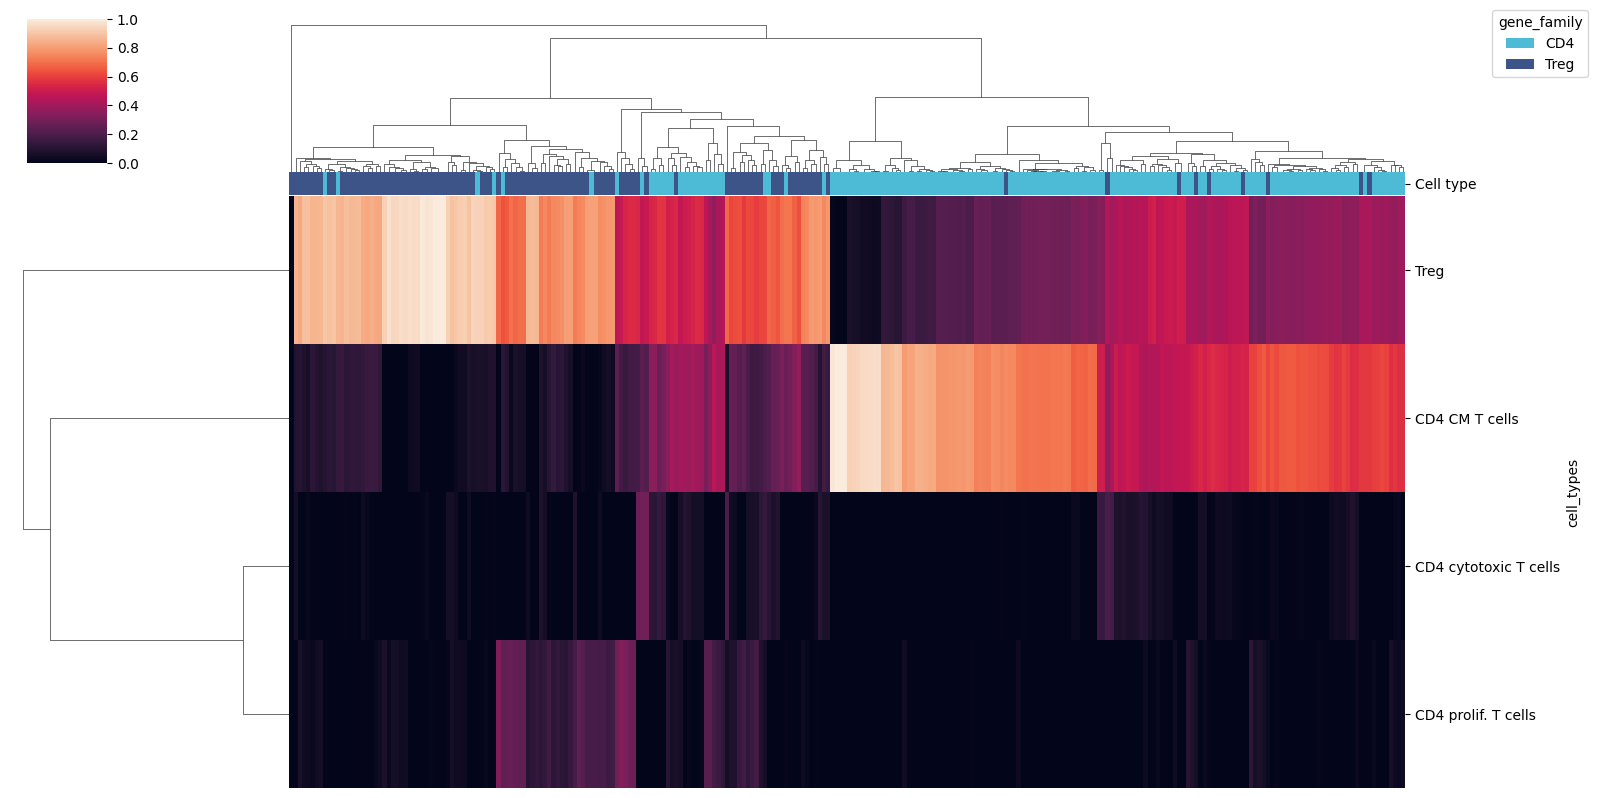

In [115]:
ax = sns.clustermap(
    proportions, 
    col_cluster=True, 
    row_cluster=True, 
    xticklabels=False, 
    figsize=(16, 8),
    col_colors=cols,
    linecolor="none",
    snap=True
)

handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='gene_family',
           bbox_to_anchor=(0, 0, 1, 1), bbox_transform=plt.gcf().transFigure, loc='best')